In [1]:
import datetime
import functools
import io
import itertools
import os
from pathlib import Path
from timeit import default_timer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%matplotlib notebook
pd.options.display.float_format = '{:.2f}'.format

# 0. Data Import + Preprocessing
*Store and transform the data into a format to allow tasks to be expressed as [SQL] queries.*

In [3]:
!cd ../data; python3 preprocess.py

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, GotPdi7ND5U93CiLruCUjAPr0R5af8PkKEZQ9UJHNlE= to 8K26YsyMwaxAbofr9cYRDbjIDwf5kYJkp1FqGZB+A=
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   user_display_name         70 non-null     object
 1   user_screen_name          70 non-null     object
 2   user_reported_location    25 non-null     object
 3   user_profile_description  27 non-null     object
 4   user_profile_url          4 non-null      object
 5   follower_count            70 non-null     int64 
 6   following_count           70 non-null     int64 
 7   account_creation_date     70 non-null     object
 8   account_language          70 non-null     object
 9   campaign                  70 non-null     object
 10  release                   70 non-null     object
 11  government                70 non-null     object
 12  file                      70 non-null     object
dtypes: i

In [8]:
campaigns = ['GRU202012']
ts = datetime.datetime.now()
log_name = '{}_{}'.format(campaigns, ts)

log = []
log.append('Datasets: {}\n'.format(campaigns))

users_combined = pd.read_csv('../data/users_combined.csv',
                             index_col='userid',
                             low_memory=False)
tweets_combined = pd.read_csv('../data/tweets_combined.csv',
                              index_col='tweetid',
                              low_memory=False)

users = users_combined[users_combined['campaign'].isin(campaigns)]
tweets = tweets_combined[tweets_combined['campaign'].isin(campaigns)]

tweets_dtypes = {
    'user_display_name':'string',
    'user_screen_name':'string',
    'user_reported_location':'string',
    'user_profile_description':'string',
    'user_profile_url':'string',
    'account_creation_date':'datetime64',
    'account_language':'string',
    'tweet_language':'string',
    'tweet_text':'string',
    'tweet_time':'datetime64',
    'tweet_client_name':'category',
    'latitude':'category',
    'longitude':'category',
    'campaign':'string',
    'government':'string',
    'file':'string'}
users_dtypes = {
    'user_display_name':'string',
    'user_screen_name':'string',
    'user_reported_location':'string',
    'user_profile_description':'string',
    'user_profile_url':'string',
    'follower_count':'int64',
    'following_count':'int64',
    'account_creation_date':'datetime64',
    'account_language':'string',
    'campaign':'string',
    'government':'string',
    'file':'string'}

tweets = tweets.astype(tweets_dtypes)
users = users.astype(users_dtypes)

# 1. Data Summarization

*For each dataset within the repo, create scripts (you can store and transform the data into a database to allow these tasks to be expressed as SQL queries as well) that
summarize the dataset in terms of:*

- *total dataset size*
- *split between tweets and retweets*
- *number of unique users involved, duration of campaign*
- *some metric of connectivity of the involved users, e.g., from the follower-following graph or alike (depending on what is accessible)*
- *(optional) average interaction received by tweets (in terms of retweets, likes, etc.).*


### Total dataset size:

In [9]:
ans = 'User dataset: {} users, {} attributes\n'.format(users.shape[0], users.shape[1])
log.append(ans)
print(ans)

ans = 'Tweets dataset: {} tweets, {} attributes\n'.format(tweets.shape[0], tweets.shape[1])
log.append(ans)
print(ans)

User dataset: 70 users, 13 attributes

Tweets dataset: 26683 tweets, 33 attributes



In [10]:
# number of accounts identified with the campaign
campaign_accounts = len(users.index)

ans = 'Number of accounts identified with campaign: {}\n'.format(campaign_accounts)
log.append(ans)
print(ans)

# number of tweets from these accounts
campaign_tweets = len(tweets.index)
ans = 'Number of tweets by identified accounts: {}\n'.format(campaign_tweets)
log.append(ans)
print(ans)

Number of accounts identified with campaign: 70

Number of tweets by identified accounts: 26683



### Duration of campaign:

In [11]:
duration = tweets.loc[:]['tweet_time'].max() - tweets.loc[:]['tweet_time'].min()

ans = 'Campaign duration: {}\n'.format(duration)
log.append(ans)
print(ans)

Campaign duration: 2542 days 10:36:00



### User statistics:

In [12]:
# query group
user_tweets = tweets.groupby('userid')

In [13]:
active_index = users.index.isin(tweets['userid'])
active_users = users[active_index]
inactive_users = users[~active_index]

In [14]:
ans = 'Active campaign accounts: {}'.format(len(active_users))
log.append(ans)
print(ans)

ans = 'Inactive campaign accounts: {}'.format(len(inactive_users))
log.append(ans)
print(ans)

ans = 'Total campaign accounts: {}'.format(len(users.index))
log.append(ans)
print(ans)

Active campaign accounts: 52
Inactive campaign accounts: 18
Total campaign accounts: 70


<IPython.core.display.Javascript object>


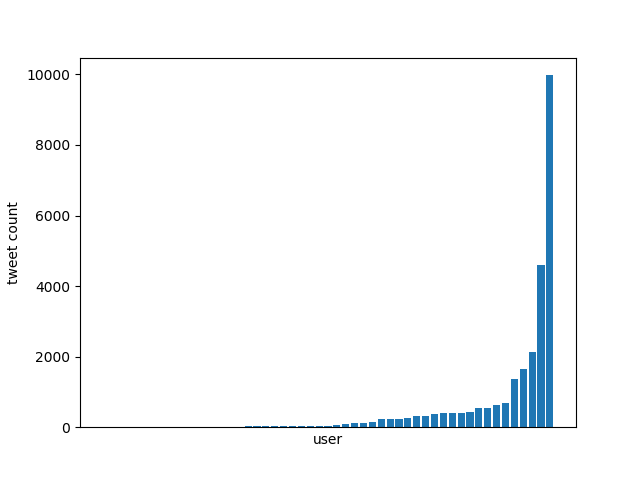

In [408]:
tweets_count = user_tweets.size().sort_values()

fig, ax = plt.subplots()
ax.bar(tweets_count.index, tweets_count)
ax.set_xticks([])
ax.set_xlabel('user')
ax.set_ylabel('tweet count')
plt.show()

### Identify top user

In [134]:
max_user = user_tweets.size().idxmax()
users[users.index == max_user]

,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,campaign,release,government,file
userid,,,,,,,,,,,,,
849852472915046400,Syria Free News,Syria_FreeNews,Syrian Arab Republic,Exclusive information about Middle East and N...,<NA>,20505,1663,2017-04-06,ru,GRU202012,202012,GRU,hashed_2020_12_GRU_202012_GRU_202012_users_csv...


### Tweets vs retweets:

In [135]:
tweets['is_retweet'].value_counts()

False    22938
True      3745
Name: is_retweet, dtype: int64

In [136]:
group_rt = tweets.groupby('is_retweet')
retweets = group_rt.get_group('True')
original_tweets = group_rt.get_group('False')

In [137]:
rt_count = retweets.size
ans = 'Count of campaign retweets: {}'.format(rt_count)
log.append(ans)
print(ans)

ot_count = original_tweets.size
ans = 'Count of campaign original tweets: {}'.format(ot_count)
log.append(ans)
print(ans)

Count of campaign retweets: 123585
Count of campaign original tweets: 756954


In [138]:
retweets = tweets.groupby(['is_retweet', 'userid'])
size = retweets.size().reset_index()

In [139]:
pivot = pd.pivot_table(size, index='userid', columns='is_retweet')
pivot = pivot.fillna(0).sort_values((0,'True'),ascending=False)

<IPython.core.display.Javascript object>


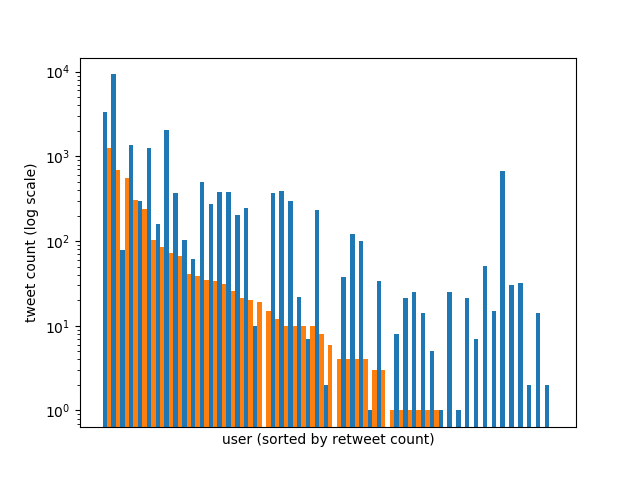

In [140]:
width = 0.5  # the width of the bars
x = np.arange(len(pivot.index))

plt.figure()
plt.bar(x - width/2, pivot[(0,'False')], width, label='original tweets')
plt.bar(x + width/2, pivot[(0,'True')], width, label='retweets')
plt.yscale('log')
plt.ylabel('tweet count (log scale)')
plt.xlabel('user (sorted by retweet count)')
plt.xticks([])
plt.show()

### Retweeted users

In [141]:
# find userids of retweets
retweeted_users = tweets.groupby('retweet_userid')

In [142]:
retweeted_users.size()

retweet_userid
135AEY00MOP1tH7YCuKyQx2xM0hG1vsl7l+0QPTliyM=     47
1lY66yW7i+XL4Fn6wRslwEStbOHd2vNXLSnJMpQjUg8=      1
3PGzTwb+Kk4yCSOyqgAZ3zPaUJ7xE3L+BSppo6ZLw8U=      3
6nDcSemH7EpMzxlBrA8G5QRpuoEj4Bl2drKLTQnWE=        2
7CQHe488W6+t0uGOqaaxoJl6O3i3IkLdR6kUJJChJvs=     25
849852472915046400                              146
883565926473486336                              110
9zxsi+qIsPp4ZaNFZCxaLJIePPypzDuzVZg97pJfU=       13
D4cAip8nhfxLE+z0BCnXrncE042+9A7rH5PCM0B1do8=      1
XY8GkjD7wdwBUNuKQguI7S9m6N4ynAjrOoBdReCxvI=       3
faQv2zTYxLMuS4ozlVw9kM660Vtwti3XfxVgoJBSMJA=      4
kdVVyjajARFWo4YfMjU6IVQ3DPKY+CbbxwgUeSPD8iw=      4
lYCjZDUvRFghu8E7fh0r2ReFhqYf00QoOAqhFPHd8s=       3
oX70apRWUW16BANgrVbdK+UVxH0NdxvC9b4HHO+aA9Y=     31
rJbjbYqkZ6B8dpTHD2mhivouulqxhiasjwpL5nqa8=        3
yCE6QGGRX4Lvm3hKCwS5Y4WlwhS4t5FhtV44LeUM=         2
dtype: int64

### Connectivity of the involved users:

Relationships users can have with tweets:
- author
- like
- quote
- retweet
- reply

Relationships users can have with users:
- replied to
- quoted
- retweeted

Relationships tweets can have with tweets (tweet x {} tweet y):
- quotes
- retweets
- replies

In [143]:
# retweets between users identified with the campaign
inside_rt = tweets[tweets['retweet_userid'].isin(users.index)]
inside_rt.groupby(['userid','retweet_userid']).size()

userid                                        retweet_userid                              
135AEY00MOP1tH7YCuKyQx2xM0hG1vsl7l+0QPTliyM=  6nDcSemH7EpMzxlBrA8G5QRpuoEj4Bl2drKLTQnWE=       2
                                              849852472915046400                              14
                                              oX70apRWUW16BANgrVbdK+UVxH0NdxvC9b4HHO+aA9Y=     1
1lY66yW7i+XL4Fn6wRslwEStbOHd2vNXLSnJMpQjUg8=  1lY66yW7i+XL4Fn6wRslwEStbOHd2vNXLSnJMpQjUg8=     1
3PGzTwb+Kk4yCSOyqgAZ3zPaUJ7xE3L+BSppo6ZLw8U=  849852472915046400                               3
                                              XY8GkjD7wdwBUNuKQguI7S9m6N4ynAjrOoBdReCxvI=      1
                                              oX70apRWUW16BANgrVbdK+UVxH0NdxvC9b4HHO+aA9Y=     2
6nDcSemH7EpMzxlBrA8G5QRpuoEj4Bl2drKLTQnWE=    3PGzTwb+Kk4yCSOyqgAZ3zPaUJ7xE3L+BSppo6ZLw8U=     2
                                              849852472915046400                              13
                                    

In [144]:
# replies between users identified with the campaign
inside_replies = tweets[tweets['in_reply_to_userid'].isin(users.index)]
inside_replies.groupby(['userid','in_reply_to_userid']).size()

userid                                        in_reply_to_userid                          
07CPSEe0H6QwZcanuJd4G4sYBjmx+NtXpcj2NdAAmr0=  kdVVyjajARFWo4YfMjU6IVQ3DPKY+CbbxwgUeSPD8iw=     1
135AEY00MOP1tH7YCuKyQx2xM0hG1vsl7l+0QPTliyM=  135AEY00MOP1tH7YCuKyQx2xM0hG1vsl7l+0QPTliyM=     3
                                              lYCjZDUvRFghu8E7fh0r2ReFhqYf00QoOAqhFPHd8s=      1
1lY66yW7i+XL4Fn6wRslwEStbOHd2vNXLSnJMpQjUg8=  1lY66yW7i+XL4Fn6wRslwEStbOHd2vNXLSnJMpQjUg8=     1
2nFqmLka396xUudTDoWTeXrpBt+q8inJmJYc3p58p4=   6rdue70c97oL6cCnqXz5tdfnePCaHuDuOuYmbpx4mF4=     1
3PGzTwb+Kk4yCSOyqgAZ3zPaUJ7xE3L+BSppo6ZLw8U=  3PGzTwb+Kk4yCSOyqgAZ3zPaUJ7xE3L+BSppo6ZLw8U=    14
6nDcSemH7EpMzxlBrA8G5QRpuoEj4Bl2drKLTQnWE=    6nDcSemH7EpMzxlBrA8G5QRpuoEj4Bl2drKLTQnWE=       3
7CQHe488W6+t0uGOqaaxoJl6O3i3IkLdR6kUJJChJvs=  7CQHe488W6+t0uGOqaaxoJl6O3i3IkLdR6kUJJChJvs=     1
8K26YsyMwaxAbofr9cYRDbjIDwf5kYJkp1FqGZB+A=    8K26YsyMwaxAbofr9cYRDbjIDwf5kYJkp1FqGZB+A=       9
9zxsi+qIsPp4ZaNFZCxaLJIePPypzDuzVZg9

### (optional) average interaction received by tweets (in terms of retweets, likes, etc.)

### Other:

#### Outliers:

In [145]:
tweets[tweets['userid'] == max_user]['account_language']

tweetid
1008783014434934784    ru
991193497477754880     ru
1006880879418007552    ru
862731233071165448     ru
1018190698108129280    ru
                       ..
1029642430621122560    ru
1011859061141311489    ru
1001722051294584832    ru
1007250044293140480    ru
1029424463144734742    ru
Name: account_language, Length: 9977, dtype: string

In [146]:
tweets[tweets['userid'] == max_user]['tweet_language'].value_counts()

ar     3962
en     3923
und    1916
ru       63
cs       56
ro       17
in        7
tr        7
de        4
es        4
tl        3
bg        2
fi        2
ja        2
et        2
ht        1
ur        1
nl        1
uk        1
ca        1
da        1
fr        1
Name: tweet_language, dtype: Int64

#### User location, account language, and tweet language

In [147]:
users['user_reported_location'].unique()

<StringArray>
[                         <NA>,     'Санкт-Петербург, Россия',
 'Хабаровск, Хабаровский край',        'Syrian Arab Republic',
                   'Уссурийск',                      'Россия',
    'Хабаровский край, Россия',                       'Syria',
        'Благовещенск, Россия',                      'Moscow',
                     'Благове',                 'Oslo, Norge',
          'Somewhere in Syria',           'Уссурийск, Россия',
                       'idlib',              'Дальний Восток',
                      'Aleppo',                      'Russia',
                       'syria',         'Владивосток, Россия',
                         'USA']
Length: 21, dtype: string

In [148]:
tweets['account_language'].unique()

<StringArray>
['ru', 'en']
Length: 2, dtype: string

In [149]:
tweets['tweet_language'].value_counts()

en     14422
ru      4797
ar      4366
und     2718
uk        71
bg        69
cs        62
es        30
in        20
ro        20
sr        18
de        18
tr        13
ca         8
tl         7
fr         6
ja         6
et         6
fa         5
fi         4
da         3
pl         3
pt         3
nl         2
ur         2
sv         1
it         1
cy         1
ht         1
Name: tweet_language, dtype: Int64

In [150]:
language_neq = tweets[tweets['account_language'] != tweets["tweet_language"]]
len(language_neq)

14364

In [151]:
lat_present = tweets[tweets["latitude"] == "present"]
len(lat_present)

0